# ELE 535 Lab 2

### Due Date: 10/3 (Mon) 11:59 PM
### Name: 

### Import required Python packages

In [46]:
# Import additional packages if needed
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.io as io

%matplotlib inline

### YALE B Dataset

You will use the YALE B face dataset to explore face recognition by classifying face images. The Yale B dataset contains frontal face images (size 192 x 168) of 38 subjects, with around 64 images per subject (not all subjects have the same number of images). The total number of images is 2,414. The images have been column-wise vectorized into 192 x 168 = 32,256 column vectors and these are stored as the columns of a matrix X. The corresponding 2,414 labels, ranging rom 1 to 39 (no 14), are provided in a row vector Y. For background and additional reading, refer to http://research.microsoft.com/pubs/132810/PAMI-Face.pdf.

### Display Some Images

In [47]:
# This cell is given. You do not need to modify.

# Functions to represent the image in matrix or column vector
def packcw(A):
    return (A.T).reshape(-1,1)

def unpackcw(x,nr):
    return x.reshape(-1,nr).T

1) Load the YALEBXF.mat face data and display the first image of 38 subjects on a 5 x 8 tile. (This part is done as an example) 

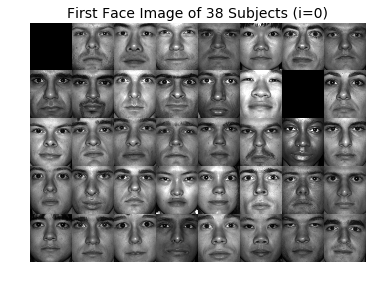

In [48]:
# This cell is given. You do not need to modify.
# You can reference this code for other questions below but just mention where you got it from.

# Load the YALE B database
YALE = io.loadmat('YALEBXF_normalized.mat') 
X = YALE['X']
Y = YALE['Y']
nr, nc = 192, 168 # height = 192, width = 168
dim = nr * nc     # dimension = 32256
nex = X.shape[1]  # Total number of examples = 2414

nFc = 40          # Total number of faces
nImg = np.zeros(nFc) # Numper of examples for each person
for i in range(nFc):
    nImg[i] = (Y==i).sum()
    
# Show the faces
# Make face board of 38 faces
faceIdx = 0 # index of face to display for each subject
Bh, Bw = 5, 8
FB = np.zeros((Bh*nr, Bw*nc))
for i in range(nFc):
    if nImg[i]>0:
        loc = np.where(Y==i)[1]
        x = X[:,loc[faceIdx]]
        A = unpackcw(x,nr)
        row, col = divmod(i,Bw)
        rpt, cpt = row*nr, col*nc
        FB[rpt:rpt+nr, cpt:cpt+nc] = A
plt.figure(figsize = (6,6))
plt.imshow(FB, cmap='gray')
plt.axis('off')
plt.title("First Face Image of 38 Subjects (i=%i)" %faceIdx, fontsize=14)
plt.show()

2) Compute the mean of all faces and center the data. Use the X.mean function but check the documentation first.

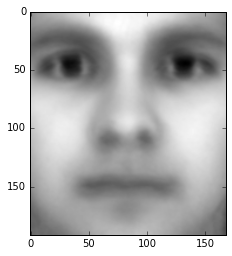

In [49]:
# for m*n matrix, calculate the 1*n mean col vector
def mean_col(mat):
    row = mat.shape[0]
    col = mat.shape[1]
    mat_mean = np.zeros(row)
    for i in range(row):
        mat_mean[i] = np.mean(mat[i,:])
    return mat_mean

# X_meanVec is the mean col vector, X_meanVec_image transform the mean into matrix
X_meanVec = mean_col(X)
X_meanVec_image = unpackcw(X_meanVec,nr)
plt.imshow(X_meanVec_image,"gray")

X_mean = np.zeros((dim,nex))    #the data after centering
for i in range(nex):
    X_mean[:,i] = X[:,i] - X_meanVec

### Singular Value Decomposition

3) Compute SVD. (Since the data set is large, it might take some time so do it once. Save each variable so you can simply load the results again when needed.)

In [50]:
# the SVD applied for centered data
U, sigma, Vh = np.linalg.svd(X_mean, full_matrices=False)

3) Plot top 200 variances (squares the singular vlaues) in order from largest to smallest and the cumulative sum of those variances. Use the functions A.sum() and A.cumsum() Where does the difference in variances start to become less significant? Mark the point as a vertical dashed line. At what index do you capture 95% of the total variance? Mark that as a second vertical line.

16
62


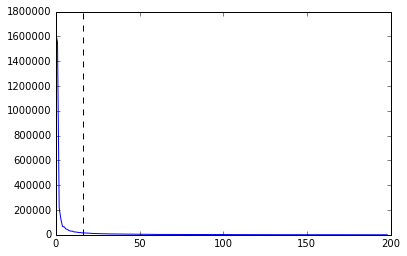

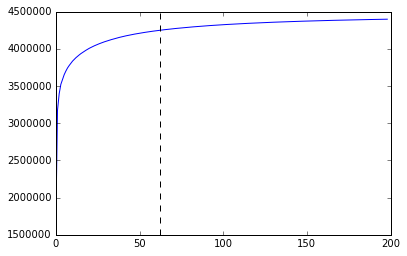

In [51]:
sigma_var = (sigma*sigma)
"""
the criterion of "difference in variances become less significant seems can have multiple answers
at here, we think if the variance of the kth eigenvalue is less than 0.1% of the maximum value, it becomes less significant
"""
sigma_varcum = sigma_var.cumsum()

mark_first = 0
mark_second = 0

sigma_var_significant = 0.01 * sigma_var[0] 

for i in range(sigma.shape[0]):
    if sigma_var[i] < sigma_var_significant:
        mark_first = i
        break

sigma_varsum = sigma_var.sum()
sigma_varsum_95 = 0.95 * sigma_varsum
for i in range(sigma.shape[0]):
    if sigma_varcum[i] > sigma_varsum_95:
        mark_second = i
        break
        
print mark_first    # first marker line at 16, i.e. the 16th eigenvalue is less than 1% of the maximum eigenvalue
print mark_second   # second marker line at 62, i.e. the cumlative sum to 62th eigenvalue exceed 95% of the total variance 

plt.figure(1)
plt.plot(sigma_var[0:199])
plt.axvline(x = mark_first,color='k',ls='dashed')
plt.figure(2)
plt.plot(sigma_varcum[0:199])
plt.axvline(x = mark_second,color='k',ls='dashed')


4) Compute the projection of data onto the first $d$ principal components for $d = 8,16,32,64,128,256$.

In [69]:
def PCA_d(X, V, d):
    U_d = V[:,0:d]  #U= VW = V*Iq*, first q column of V
    #U_d_project = np.dot(U_d, np.transpose(U_d))
    #X_PCAd = np.dot(U_d_project, X_mean)
    X_PCAd = np.dot(np.transpose(U_d), X_mean)
    return X_PCAd

In [79]:
# No need to do eigenvalue decomposition for XTX, the V matrix is the same as U in SVD for X
X_mean_PCA8 = PCA_d(X_mean,U,8)
X_mean_PCA16 = PCA_d(X_mean,U,16)
X_mean_PCA32 = PCA_d(X_mean,U,32)
X_mean_PCA64 = PCA_d(X_mean,U,64)
X_mean_PCA128 = PCA_d(X_mean,U,128)
X_mean_PCA256 = PCA_d(X_mean,U,256)

5) Approximate the original image from the projected data onto first $d$ principal components for $d = 8,16,32,64,128,256$. Then, display the approximate faces for the same images from 1) in a 5 x 8 tile. Remember to add back the mean before displaying the image.

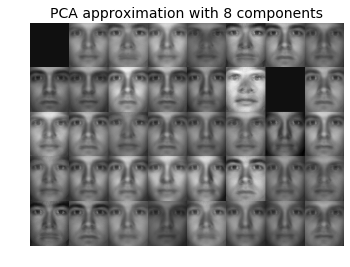

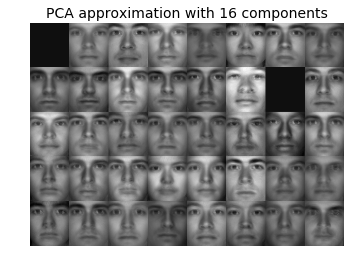

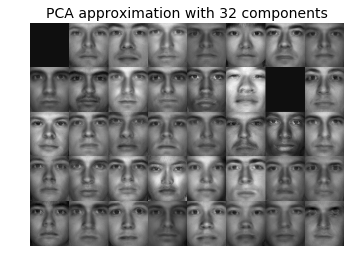

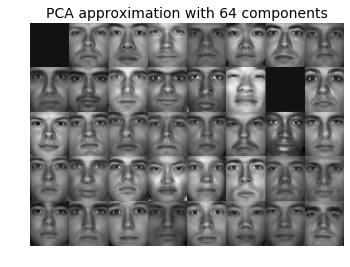

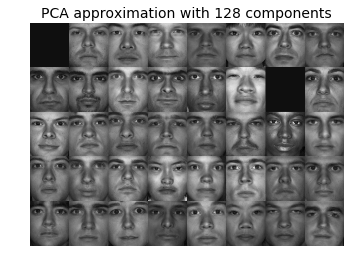

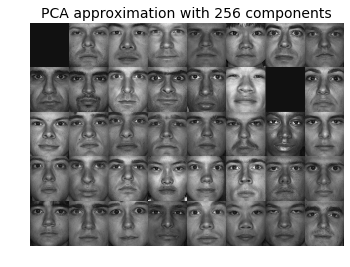

In [84]:
# input is the X_mean data
def image_all(X_PCA, X_meanVec, Bh, Bw, nFc, nr, nc, nImg, U):
    X = np.dot(U, X_PCA)
    for i in range(nex):
        X[:,i] = X[:,i] + X_meanVec
    FB = np.zeros((Bh*nr, Bw*nc))
    for i in range(nFc):
        if nImg[i]>0:
            loc = np.where(Y==i)[1]
            x = X[:,loc[faceIdx]]
            A = unpackcw(x,nr)
            row, col = divmod(i,Bw)
            rpt, cpt = row*nr, col*nc
            FB[rpt:rpt+nr, cpt:cpt+nc] = A
    return FB

plt.figure(1)
FB_PCA8 = image_all(X_mean_PCA8, X_meanVec, Bh, Bw, nFc, nr, nc, nImg, U[:,0:8])
plt.imshow(FB_PCA8, cmap='gray')
plt.axis('off')
plt.title("PCA approximation with 8 components", fontsize=14)

plt.figure(2)
FB_PCA16 = image_all(X_mean_PCA16, X_meanVec, Bh, Bw, nFc, nr, nc, nImg, U[:,0:16])
plt.imshow(FB_PCA16, cmap='gray')
plt.axis('off')
plt.title("PCA approximation with 16 components", fontsize=14)

plt.figure(3)
FB_PCA32 = image_all(X_mean_PCA32, X_meanVec, Bh, Bw, nFc, nr, nc, nImg, U[:,0:32])
plt.imshow(FB_PCA32, cmap='gray')
plt.axis('off')
plt.title("PCA approximation with 32 components", fontsize=14)

plt.figure(4)
FB_PCA64 = image_all(X_mean_PCA64, X_meanVec, Bh, Bw, nFc, nr, nc, nImg, U[:,0:64])
plt.imshow(FB_PCA64, cmap='gray')
plt.axis('off')
plt.title("PCA approximation with 64 components", fontsize=14)

plt.figure(5)
FB_PCA128 = image_all(X_mean_PCA128, X_meanVec, Bh, Bw, nFc, nr, nc, nImg, U[:,0:128])
plt.imshow(FB_PCA128, cmap='gray')
plt.axis('off')
plt.title("PCA approximation with 128 components", fontsize=14)

plt.figure(6)
FB_PCA256 = image_all(X_mean_PCA256, X_meanVec, Bh, Bw, nFc, nr, nc, nImg, U[:,0:256])
plt.imshow(FB_PCA256, cmap='gray')
plt.axis('off')
plt.title("PCA approximation with 256 components", fontsize=14)


### Nearest Neighbor Classifier

1) Write functions to implement nearest neighbor classifier to classify the faces on the test data and report the accuracy.

In [38]:
# the code is similar as hw1, but change to nearest neighbor classifier
# calculate the norm of two vector
def vector_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

# for each input vector, calculate the nearest neighbour of picture, according to the norm
def nearest_neighbour(x, train, label_train, N):
    min_dist = float('inf')
    min_set = -1
    for i in range(0,N):
        if vector_distance(x,train[i]) < min_dist :
            min_dist = vector_distance(x, train[i])
            min_set = i
    return label_train[min_set]

# given M sample for test, return nearest neighbour(N distinct element)
def nearest_array(test, train, label_train, N, M):
    result = np.zeros(M)
    for i in range(0, M):
        result[i] = nearest_neighbour(test[i], train, label_train, N)
    return result
# given test/train data and label, and the size of the test and train data, return accuracy of the label 
def nearest_accuracy(test, train, label, label_train, N, M):
    result = nearest_array(test, train, label_train, N, M)
    accuracy = 0
    for i in range(M):
        if result[i] == label[i]:
            accuracy = accuracy + 1./M
    return accuracy

# calculate the mean of each face
trainNum = 50
X_count = np.zeros(nFc)
test_count = 0
train_count = 0
X_test = np.zeros((nex,dim))     #test data
X_train = np.zeros((nex,dim))    #train data
Y_test = np.zeros(nex)           #test label
Y_train = np.zeros(nex)          #train label
for i in range(nex):
    X_count[Y[0][i]] = X_count[Y[0][i]] + 1
    # count each picture's number, first 50 use as train, the rest as test
    if X_count[Y[0][i]] <= 50:    
        X_train[train_count] = X[:,i]
        Y_train[train_count] = Y[0][i]
        train_count = train_count + 1
    else:
        X_test[test_count] = X[:,i]
        Y_test[test_count] = Y[0][i]
        test_count = test_count + 1

X_test = X_test[0:test_count]
Y_test = Y_test[0:test_count]
X_train = X_train[0:train_count]
Y_train = Y_train[0:train_count]

#print vector_distance(X_test[0],X_train[0])
#print nearest_neighbour(X_test[7], X_train, Y_train, train_count)
#print nearest_array(X_test, X_train, Y_train, train_count, test_count)

# apply the nearest_neighbour classifier, calculate the accuracy
print nearest_accuracy(X_test, X_train, Y_test, Y_train, train_count,test_count)


"""
if we use the nearest sample mean classifier, we will get the accuracy of 6.23%, which is much smaller than the accuracy
of nearest neighbour classifier
intuitively, it is reasonable to use nearest neighbour, since the "match" of the photo does not necessarily match every 
picture, just need to be very similar to one of them
"""


0.412451361868


'\nif we use the nearest sample mean classifier, we will get the accuracy of 6.23%, which is much smaller than the accuracy\nof nearest neighbour classifier\nintuitively, it is reasonable to use nearest neighbour, since the "match" of the photo does not necessarily match every \npicture, just need to be very similar to one of them\n'

2) Apply nearest neighbor classifier for the data projected on $d$ principal components for $d = 8,16,32,64,128,256$. Plot the dimension vs. accuracy graph. How does the dimension affect the accuracy of the classification?

In [99]:
# original data, 0.41245
# pca8 0.066
# give X, Y, automatically calculate X_text, X_train

def nearest_result(X, U, Y0, nFc, nex):
    X0 = np.dot(U, X)   #U * (UT)X
    trainNum = 50
    X0_count = np.zeros(nFc)
    test_count = 0
    train_count = 0
    X0_test = np.zeros((nex,dim))     #test data
    X0_train = np.zeros((nex,dim))    #train data
    Y0_test = np.zeros(nex)           #test label
    Y0_train = np.zeros(nex)          #train label
    for i in range(nex):
        X0_count[Y[0][i]] = X0_count[Y[0][i]] + 1
    # count each picture's number, first 50 use as train, the rest as test
        if X0_count[Y[0][i]] <= 50:    
            X0_train[train_count] = X0[:,i]
            Y0_train[train_count] = Y0[0][i]
            train_count = train_count + 1
        else:
            X0_test[test_count] = X0[:,i]
            Y0_test[test_count] = Y0[0][i]
            test_count = test_count + 1
    X0_test = X0_test[0:test_count]
    Y0_test = Y0_test[0:test_count]
    X0_train = X0_train[0:train_count]
    Y0_train = Y0_train[0:train_count]
    return nearest_accuracy(X0_test, X0_train, Y0_test, Y0_train, train_count,test_count)



In [91]:
# accuracy_MNIST_PCA array store the accuracy for different d value
d_PCA = [8,16,32,64,128,256]
accuracy_MNIST_PCA = np.zeros(np.size(d_PCA))
accuracy_MNIST_PCA[0] = nearest_result(X_mean_PCA8, U[:,0:8], Y, nFc, nex)
accuracy_MNIST_PCA[1] = nearest_result(X_mean_PCA16, U[:,0:16], Y, nFc, nex)
accuracy_MNIST_PCA[2] = nearest_result(X_mean_PCA32, U[:,0:32], Y, nFc, nex)
accuracy_MNIST_PCA[3] = nearest_result(X_mean_PCA64, U[:,0:64], Y, nFc, nex)
accuracy_MNIST_PCA[4] = nearest_result(X_mean_PCA128, U[:,0:128], Y, nFc, nex)
accuracy_MNIST_PCA[5] = nearest_result(X_mean_PCA256, U[:,0:256], Y, nFc, nex)

array of d = [8, 16, 32, 64, 128, 256]
array of accuracy = [ 0.06614786  0.13035019  0.26459144  0.3540856   0.39688716  0.41634241]


'\nWe can see that the accuracy increases with the increase of the dimension, but the slope of \ndecreases when d goes high, when d reach 128, it is almost the same as the prediction with original value, \nthe benefit from 128(39.7%) to 256(41.6%) is very limited\n'

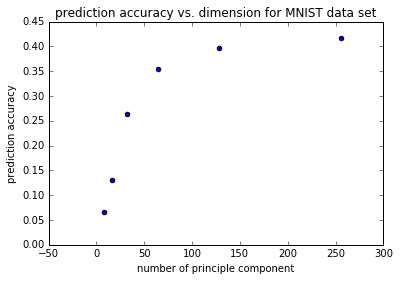

In [98]:
for i in range(np.size(d_PCA)):
     plt.scatter(d_PCA[i], accuracy_MNIST_PCA[i])
plt.xlabel("number of principle component")
plt.ylabel("prediction accuracy")
plt.title("prediction accuracy vs. dimension for MNIST data set")

print 'array of d =', d_PCA
print 'array of accuracy =', accuracy_MNIST_PCA

"""
We can see that the accuracy increases with the increase of the dimension, but the slope of 
decreases when d goes high, when d reach 128, it is almost the same as the prediction with original value, 
the benefit from 128(39.7%) to 256(41.6%) is very limited
"""